## 📚 Prerequisites

Ensure that your Azure Services are properly set up, your Conda environment is created, and your environment variables are configured as per the instructions in the [SETTINGS.md](SETTINGS.md) file.

## 📋 Table of Contents

This notebook assists in testing and retrieving the headers of Azure OpenAI, covering the following sections:

1. [**Setting Up Azure OpenAI Client**](#setting-up-azure-openai-client): Outlines the process of initializing the Azure OpenAI client.

2. [**Calling Azure OpenAI API**](#calling-azure-openai-api): Discusses how to make API calls to Azure OpenAI.

3. [**Extracting Headers and Payload Metadata**](#extracting-headers-and-payload-metadata): Explores how to extract headers and payload metadata from the API response.

4. [**Analyzing Rate Limit Info**](#analyzing-rate-limit-info): Details the steps to analyze the rate limit information from the API response.

For additional information, refer to the following resources:
- [AOAI API Documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/reference)

In [1]:
import os

# Define the target directory
target_directory = (
    r"C:\Users\pablosal\Desktop\gbbai-azure-aoai-faq"  # change your directory here
)

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-aoai-faq


## Setting Up Azure OpenAI Client   

In [2]:
# Create an instance of the client. You can find it in src/aoai/azure_openai.py.
# It is essentially a wrapper using dependency injection to automate the initialization
# and most used API calls.
from src.aoai.azure_openai import AzureOpenAIManager
from typing import Union, Optional, List, Dict
import tiktoken
from utils.ml_logging import get_logger

# Set up logger
logger = get_logger()

azure_openai_client = AzureOpenAIManager()

## Estimating Token Usage for Azure OpenAI Models

In [3]:
def estimate_tokens_azure_openai(
    messages: List[Dict[str, Union[str, int]]],
    model: str = "gpt-3.5-turbo-0613",
    has_function_call: bool = False,
) -> int:
    """
    Estimates the number of tokens used by a list of messages for a specific OpenAI model.

    This function estimates the token count for a given set of messages based on the model's specific encoding and formatting rules.

    :param messages (List[Dict[str, Union[str, int]]]): A list of messages, each represented as a dictionary.
    :param model (str): The model name, which determines the encoding and token counting rules. Default is "gpt-3.5-turbo-0613".
    :param has_function_call (bool): Flag to indicate if there is a function call in the messages, which affects token count.

    :return (int): The estimated number of tokens for the provided messages.
    """
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        logger.warning("Model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")

    tokens_per_message = {
        "gpt-3.5-turbo-0613": 3,
        "gpt-3.5-turbo-16k-0613": 3,
        "gpt-4-0314": 3,
        "gpt-4-32k-0314": 3,
        "gpt-4-0613": 3,
        "gpt-4-32k-0613": 3,
        "gpt-3.5-turbo-0301": 4,
    }.get(model, 3)

    tokens_per_name = {
        "gpt-3.5-turbo-0301": -1,
    }.get(model, 1)

    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            if key in ["role", "content", "name"] and isinstance(value, str):
                num_tokens += len(encoding.encode(value))
                if key == "name":
                    num_tokens += tokens_per_name

    # Adjust for function calls
    if has_function_call:
        num_tokens += 9

    # Priming for each reply with 'assistant'
    num_tokens += 3

    return num_tokens

### Chat Completion model

#### Constructing the Request

- **max_tokens**: Optional. Integer specifying the maximum number of tokens to generate. Default is 24.
- **temperature**: Optional. Number between 0 and 1 indicating the sampling temperature. Default is 1.
- **top_p**: Optional. Nucleus sampling parameter as a number between 0 and 1. Default is 1.
- **user**: Optional. A unique identifier for the end-user to help monitor and detect abuse.
- **n**: Optional. Integer for the number of completions to generate for each prompt. Default is 1.
- **presence_penalty**: Optional. Number between -2.0 and 2.0 to penalize new tokens based on presence in the text so far. Default is 0.
- **frequency_penalty**: Optional. Number between -2.0 and 2.0 to penalize new tokens based on frequency in the text so far. Default is 0.
- **messages**: An array of message objects.

You can learn more about the aoai API  [official documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/reference).

In [4]:
body = {
    "max_tokens": 24,
    "temperature": 1,
    "top_p": 1,
    "user": "",
    "n": 1,
    "presence_penalty": 0,
    "frequency_penalty": 0,
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Does Azure OpenAI support customer managed keys?"},
        {
            "role": "assistant",
            "content": "Yes, customer managed keys are supported by Azure OpenAI.",
        },
        {"role": "user", "content": "Do other Azure AI services support this too?"},
        {
            "role": "assistant",
            "content": "Yes, other Azure AI services also support customer managed keys.",
        },
        {"role": "user", "content": "Can you tell me more about these services?"},
        {
            "role": "assistant",
            "content": "Sure, Azure AI services include Azure Cognitive Services, Azure Machine Learning, and more.",
        },
        {"role": "user", "content": "What is Azure Cognitive Services?"},
        {
            "role": "assistant",
            "content": "Azure Cognitive Services is a collection of APIs and services for building intelligent applications.",
        },
        {"role": "user", "content": "What is Azure Machine Learning?"},
        {
            "role": "assistant",
            "content": "Azure Machine Learning is a cloud-based service for building, training, and deploying machine learning models.",
        },
        {"role": "user", "content": "Thank you for the information."},
        {
            "role": "assistant",
            "content": "You're welcome! If you have any other questions, feel free to ask.",
        },
        {"role": "user", "content": "What other services does Azure offer?"},
        {
            "role": "assistant",
            "content": "Azure offers a wide range of services including computing, analytics, storage, and networking.",
        },
        {
            "role": "user",
            "content": "Can you tell me more about Azure's computing services?",
        },
        {
            "role": "assistant",
            "content": "Azure's computing services include virtual machines, container services, and serverless computing.",
        },
        {"role": "user", "content": "What is serverless computing?"},
        {
            "role": "assistant",
            "content": "Serverless computing is a cloud computing model where the cloud provider automatically manages the provisioning and scaling of servers.",
        },
        {
            "role": "user",
            "content": "That's interesting. Thank you for the information.",
        },
        {
            "role": "assistant",
            "content": "You're welcome! If you have any other questions, feel free to ask.",
        },
    ],
}

In [5]:
estimate_tokens_azure_openai(messages=body["messages"], model="gpt-4-0613")

333

## 🧪 Testing the Token Counting 

In [6]:
from utils.chat_prompts.prompts_test import (
    HEALTHY_EATING_CHAT_PROMPTS,
    ONLINE_EDUCATION_CHAT_PROMPTS,
    SMART_TECHNOLOGY_CHAT_PROMPTS,
    AUGMENTED_REALITY_CHAT_PROMPTS,
    ELECTRIC_VEHICLE_CHAT_PROMPTS,
    SPACE_TOURISM_CHAT_PROMPTS,
    RENEWABLE_ENERGY_CHAT_PROMPTS,
    AUTONOMOUS_VEHICLES_CHAT_PROMPTS,
    VIRTUAL_REALITY_CHAT_PROMPTS,
    AI_TECHNOLOGY_CHAT_PROMPTS,
)

all_conversations = [
    HEALTHY_EATING_CHAT_PROMPTS,
    ONLINE_EDUCATION_CHAT_PROMPTS,
    SMART_TECHNOLOGY_CHAT_PROMPTS,
    AUGMENTED_REALITY_CHAT_PROMPTS,
    ELECTRIC_VEHICLE_CHAT_PROMPTS,
    SPACE_TOURISM_CHAT_PROMPTS,
    RENEWABLE_ENERGY_CHAT_PROMPTS,
    AUTONOMOUS_VEHICLES_CHAT_PROMPTS,
    VIRTUAL_REALITY_CHAT_PROMPTS,
    AI_TECHNOLOGY_CHAT_PROMPTS,
]

In [7]:
from src.aoai.utils import (
    calculate_accuracy,
    display_token_results_table,
    plot_token_analysis_results,
)

In [8]:
# Analyze conversations
(
    results,
    total_estimated,
    total_actual,
) = azure_openai_client.analyze_chat_completion_token_count_results(
    all_conversations, "gpt-4-0613"
)

# Display results in a table
display_token_results_table(results)

              Estimated Tokens  Actual Tokens
Conversation                                 
0                          451            451
1                          313            313
2                          375            375
3                          377            377
4                          336            336
5                          392            392
6                          755            755
7                          137            137
8                          132            132
9                          174            174
Total                     3442           3442


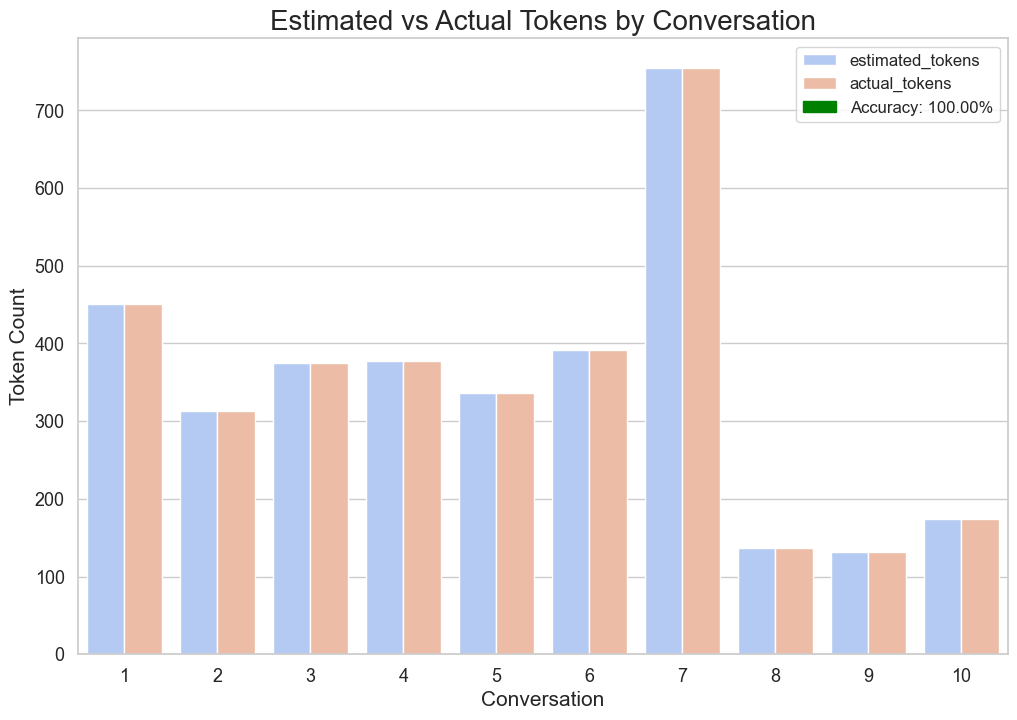

In [14]:
# Plot the results
plot_token_analysis_results(results, total_estimated, total_actual)

In [15]:
# Calculate and print accuracy
accuracy = calculate_accuracy(total_estimated, total_actual)

2024-01-28 13:19:54,776 - micro - MainProcess - INFO     Accuracy: 100.0% (utils.py:calculate_accuracy:48)
